## Import modules

In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import holoviews as hv
import geoviews as gv
import geoviews.feature as gf
import xarray as xr
from cartopy import crs

hv.notebook_extension()
%matplotlib inline

## Note: All calculations can be performed *before* load().  
## Plots require load() but can plot subset of data as a test

## Open NDVI_ll NetCDFs

In [2]:
ds_all=xr.open_mfdataset(
    '/g/data/oe9/project/team-drip/modis_h30v12_ndvi_latlon/h30v12_reflectance_????.nc',
    chunks=dict(time=12, x=1200), #chunks should be in multiples of saved chunk size
)
ds_all

<xarray.Dataset>
Dimensions:          (time: 1564, x: 2400, y: 1680)
Coordinates:
  * x                (x) float64 1.334e+07 1.334e+07 1.334e+07 1.334e+07 ...
  * y                (y) float64 -3.336e+06 -3.336e+06 -3.337e+06 -3.337e+06 ...
  * time             (time) datetime64[ns] 2001-01-01 2001-01-05 2001-01-09 ...
Data variables:
    red_630_690      (time, y, x) float32 dask.array<shape=(1564, 1680, 2400), chunksize=(12, 1680, 1200)>
    nir1_780_900     (time, y, x) float32 dask.array<shape=(1564, 1680, 2400), chunksize=(12, 1680, 1200)>
    blue_450_520     (time, y, x) float32 dask.array<shape=(1564, 1680, 2400), chunksize=(12, 1680, 1200)>
    green_530_610    (time, y, x) float32 dask.array<shape=(1564, 1680, 2400), chunksize=(12, 1680, 1200)>
    nir2_1230_1250   (time, y, x) float32 dask.array<shape=(1564, 1680, 2400), chunksize=(12, 1680, 1200)>
    swir1_1550_1750  (time, y, x) float32 dask.array<shape=(1564, 1680, 2400), chunksize=(12, 1680, 1200)>
    swir2_2090_2350  (

In [20]:
ds_all.nbytes/10**9

176.569389152

In [63]:
import collections, math
import numpy as np
from osgeo import gdal, gdal_array, osr

AffineGeoTransform = collections.namedtuple(
    'GeoTransform', ['origin_x', 'pixel_width', 'x_rot',
                     'origin_y', 'y_rot', 'pixel_height'])


def get_geot(ds):
    """Take an Xarray object with x and y coords; return geotransform."""
    return AffineGeoTransform(*map(float, (
        # Affine matrix - start/step/rotation, start/rotation/step - in 1D
        ds.x[0], (ds.x[-1] - ds.x[0]) / ds.x.size, 0,
        ds.y[0], 0, (ds.y[-1] - ds.y[0]) / ds.y.size
    )))


class aus:
    start_lat = -30
    stop_lat = -37
    start_lon = 138
    stop_lon = 153

out_res_degrees = 0.005

ll_geot = AffineGeoTransform(
    origin_x=aus.start_lon, pixel_width=out_res_degrees, x_rot=0,
    origin_y=aus.start_lat, y_rot=0, pixel_height=-out_res_degrees
)

new_shape = (
    math.ceil((aus.start_lat - aus.stop_lat) / out_res_degrees),
    math.ceil((aus.stop_lon - aus.start_lon) / out_res_degrees),
)

ll_coords = dict(
    latitude=np.arange(new_shape[0]) * ll_geot.pixel_height + ll_geot.origin_y,
    longitude=np.arange(new_shape[1]) * ll_geot.pixel_width + ll_geot.origin_x,
)

# MAGIC - describes the MODIS projection
wkt_str = (
    'PROJCS["Sinusoidal",GEOGCS["GCS_Undefined",DATUM["Undefined",'
    'SPHEROID["User_Defined_Spheroid",6371007.181,0.0]],PRIMEM["Greenwich",0.0],'
    'UNIT["Degree",0.0174532925199433]],PROJECTION["Sinusoidal"],'
    'PARAMETER["False_Easting",0.0],PARAMETER["False_Northing",0.0],'
    'PARAMETER["Central_Meridian",0.0],UNIT["Meter",1.0]]"'
)


# Next, define some generically useful functions:


def project_array(array, geot=None):
    """Reproject a tile from Modis Sinusoidal to WGS84 Lat/Lon coordinates.
    Metadata is handled by the calling function.
    """
    # Takes around seven seconds per layer for in-memory Australia mosaics
    if geot is None:
        geot = get_geot(array)
    assert isinstance(geot, AffineGeoTransform)

    def array_to_raster(array, geot):
        ysize, xsize = array.shape  # unintuitive order, but correct!
        dataset = gdal.GetDriverByName('MEM').Create(
            '', xsize, ysize,
            eType=gdal_array.NumericTypeCodeToGDALTypeCode(array.dtype))
        dataset.SetGeoTransform(geot)
        dataset.SetProjection(wkt_str)
        dataset.GetRasterBand(1).WriteArray(array)
        return dataset

    if isinstance(array, xr.DataArray):
        array = array.values
    input_data = array_to_raster(array, geot)

    # Set up the reference systems and transformation
    from_sr = osr.SpatialReference()
    from_sr.ImportFromWkt(wkt_str)
    to_sr = osr.SpatialReference()
    to_sr.SetWellKnownGeogCS("WGS84")

    # Get new geotransform and create destination raster
    dest_arr = np.empty(new_shape)
    dest_arr[:] = np.nan
    dest = array_to_raster(dest_arr, ll_geot)

    # Perform the projection/resampling
    gdal.ReprojectImage(
        input_data, dest,
        wkt_str, to_sr.ExportToWkt(),
        gdal.GRA_NearestNeighbour)

    return xr.DataArray(
        dest.GetRasterBand(1).ReadAsArray(),
        dims=('latitude', 'longitude'),
        coords=ll_coords)

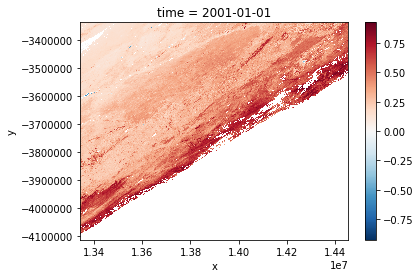

In [55]:
dat = ndvi.isel(time=0).load()
dat.plot.imshow()

In [64]:
ll = project_array(dat)
ll

<xarray.DataArray (latitude: 1400, longitude: 3000)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * latitude   (latitude) float64 -30.0 -30.0 -30.01 -30.02 -30.02 -30.02 ...
  * longitude  (longitude) float64 138.0 138.0 138.0 138.0 138.0 138.0 138.0 ...

In [66]:
out.diff('time').plot.imshow(col='time', robust=True)

<xarray.DataArray (latitude: 1400, longitude: 3000)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * latitude   (latitude) float64 -30.0 -30.0 -30.01 -30.02 -30.02 -30.02 ...
  * longitude  (longitude) float64 138.0 138.0 138.0 138.0 138.0 138.0 138.0 ...

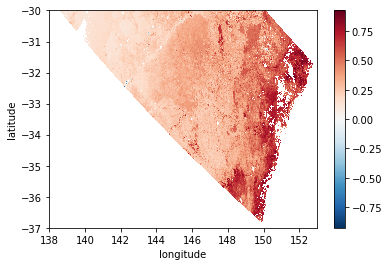

In [65]:
ll.plot.imshow()

# Calculate NDVI and EVI

In [3]:
# rename vars for simple calcs
blue = ds_all.blue_450_520
green = ds_all.green_530_610
red = ds_all.red_630_690
nir1 = ds_all.nir1_780_900
nir2 = ds_all.nir2_1230_1250

In [4]:
ndvi = (nir1 - red) / (nir1 + red)
ndvi

<xarray.DataArray (time: 1564, y: 1680, x: 2400)>
dask.array<shape=(1564, 1680, 2400), dtype=float32, chunksize=(12, 1680, 1200)>
Coordinates:
  * x        (x) float64 1.334e+07 1.334e+07 1.334e+07 1.334e+07 1.335e+07 ...
  * y        (y) float64 -3.336e+06 -3.336e+06 -3.337e+06 -3.337e+06 ...
  * time     (time) datetime64[ns] 2001-01-01 2001-01-05 2001-01-09 ...

In [20]:
# Using the MODIS-EVI coefficients
L, C1, C2, G = 1, 6, 7.5, 2.5
evi = G * ((nir1 - red) / (nir1 + C1 * red - C2 * blue + L))


## Manipulation via time.season & groupby()

In [21]:
#like accumarray, group by season and perform function
# creates seasonal averages for whole time series
seasonal = ndvi.groupby('time.season').mean(dim='time')
seasonal


<xarray.DataArray (season: 4, y: 1680, x: 2400)>
dask.array<shape=(4, 1680, 2400), dtype=float32, chunksize=(1, 1680, 1200)>
Coordinates:
  * x        (x) float64 1.334e+07 1.334e+07 1.334e+07 1.334e+07 1.335e+07 ...
  * y        (y) float64 -3.336e+06 -3.336e+06 -3.337e+06 -3.337e+06 ...
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

In [22]:
#create seasonal object by extracting from seasonal dataarray
nJJA=seasonal.sel(season='JJA')
nDJF=seasonal.sel(season='DJF')
nJJA

<xarray.DataArray (y: 1680, x: 2400)>
dask.array<shape=(1680, 2400), dtype=float32, chunksize=(1680, 1200)>
Coordinates:
  * x        (x) float64 1.334e+07 1.334e+07 1.334e+07 1.334e+07 1.335e+07 ...
  * y        (y) float64 -3.336e+06 -3.336e+06 -3.337e+06 -3.337e+06 ...
    season   <U3 'JJA'

In [ ]:
climatology = ndvi.groupby('time.month').mean('time')
climatology

/g/data/oe9/software/anaconda/envs/geo/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/oe9/software/anaconda/envs/geo/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


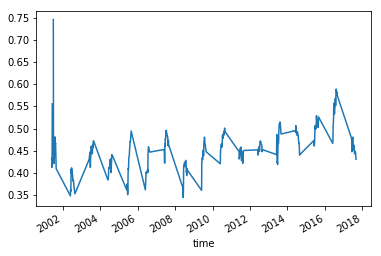

In [15]:
%%time
#extract all timesteps in a given season
ndvi_jja=ndvi.sel(time=ndvi['time.season']=='JJA')
ndvi_jja_m=ndvi_jja.mean(dim=('x','y'))
ndvi_jja_m.plot()

## Play with resampling aliases to create yearly seasonal averages

In [42]:
#resample dataset to quarterly with year ending in Nov, resample by meaning included timesteps
ndvi_rs=ndvi.resample('M').mean(dim='time')
ndvi_rs=ndvi.resample(time='time.season').mean(dim='time')
ndvi_rs


/g/data/oe9/software/anaconda/envs/geo/lib/python3.6/site-packages/xarray/core/common.py:594: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)


<xarray.DataArray (time: 69, y: 1680, x: 2400)>
dask.array<shape=(69, 1680, 2400), dtype=float32, chunksize=(1, 1680, 1200)>
Coordinates:
  * time     (time) datetime64[ns] 2001-02-28 2001-05-31 2001-08-31 ...
  * x        (x) float64 1.334e+07 1.334e+07 1.334e+07 1.334e+07 1.335e+07 ...
  * y        (y) float64 -3.336e+06 -3.336e+06 -3.337e+06 -3.337e+06 ...

In [32]:
ndvi_jja=ndvi_rs.where(ndvi_rs['time.season']=='JJA', drop=True)
ndvi_jja_m=ndvi_jja.mean(dim=('x','y'))
ndvi_djf=ndvi_rs.where(ndvi_rs['time.season']=='DJF', drop=True)
ndvi_djf_m=ndvi_jja.mean(dim=('x','y'))
ndvi_djf.time


<xarray.DataArray 'time' (time: 18)>
array(['2001-02-28T00:00:00.000000000', '2002-02-28T00:00:00.000000000',
       '2003-02-28T00:00:00.000000000', '2004-02-29T00:00:00.000000000',
       '2005-02-28T00:00:00.000000000', '2006-02-28T00:00:00.000000000',
       '2007-02-28T00:00:00.000000000', '2008-02-29T00:00:00.000000000',
       '2009-02-28T00:00:00.000000000', '2010-02-28T00:00:00.000000000',
       '2011-02-28T00:00:00.000000000', '2012-02-29T00:00:00.000000000',
       '2013-02-28T00:00:00.000000000', '2014-02-28T00:00:00.000000000',
       '2015-02-28T00:00:00.000000000', '2016-02-29T00:00:00.000000000',
       '2017-02-28T00:00:00.000000000', '2018-02-28T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2001-02-28 2002-02-28 2003-02-28 ...

In [45]:
ndvi_jja.time

<xarray.DataArray 'time' (time: 17)>
array(['2001-08-31T00:00:00.000000000', '2002-08-31T00:00:00.000000000',
       '2003-08-31T00:00:00.000000000', '2004-08-31T00:00:00.000000000',
       '2005-08-31T00:00:00.000000000', '2006-08-31T00:00:00.000000000',
       '2007-08-31T00:00:00.000000000', '2008-08-31T00:00:00.000000000',
       '2009-08-31T00:00:00.000000000', '2010-08-31T00:00:00.000000000',
       '2011-08-31T00:00:00.000000000', '2012-08-31T00:00:00.000000000',
       '2013-08-31T00:00:00.000000000', '2014-08-31T00:00:00.000000000',
       '2015-08-31T00:00:00.000000000', '2016-08-31T00:00:00.000000000',
       '2017-08-31T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2001-08-31 2002-08-31 2003-08-31 ...

/g/data/oe9/software/anaconda/envs/geo/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/g/data/oe9/software/anaconda/envs/geo/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CPU times: user 11min 4s, sys: 1min 2s, total: 12min 7s
Wall time: 10min 50s


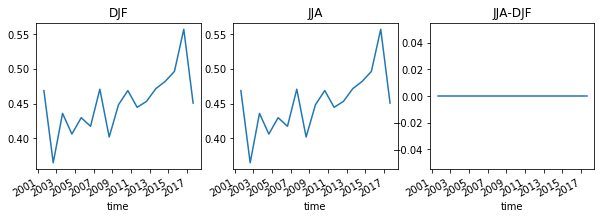

In [44]:
%%time
fig=plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
ndvi_djf_m.plot()
plt.title('DJF')
plt.subplot(1,3,2)
ndvi_jja_m.plot()
plt.title('JJA')
plt.subplot(1,3,3)
diff=ndvi_jja_m-ndvi_djf_m;
diff.plot()
plt.title('JJA-DJF')

## Plotting slices

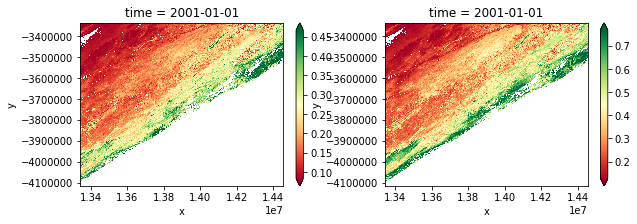

In [15]:
##plot
fig=plt.figure(figsize=(10,2))
plt.subplot(1,2,1)
plt.title('h30v12')
evi.isel(time=0).plot.imshow(robust=True,cmap='RdYlGn')

plt.subplot(1,2,2)
ndvi.isel(time=0).plot.imshow(robust=True,cmap='RdYlGn')

In [ ]:
seasonal.plot.imshow(col='season', robust=True, cmap='RdYlGn')

In [ ]:
%%time
gseas = gv.Dataset(seasonal, kdims=['x', 'y', 'season'], vdims=['evi'],rs=crs.PlateCarree())
gseas.to(gv.Image, ['x', 'y'])

/g/data/oe9/software/anaconda/envs/geo/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/oe9/software/anaconda/envs/geo/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/oe9/software/anaconda/envs/geo/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/g/data/oe9/software/anaconda/envs/geo/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/oe9/software/anaconda/envs/geo/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/g/data/oe9/software/anaconda/envs/geo/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: inva

KeyboardInterrupt: 

ERROR:tornado.general:Uncaught exception, closing connection.
Traceback (most recent call last):
  File "/g/data/oe9/software/anaconda/envs/geo/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/g/data/oe9/software/anaconda/envs/geo/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/g/data/oe9/software/anaconda/envs/geo/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 281, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/g/data/oe9/software/anaconda/envs/geo/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 232, in dispatch_shell
    handler(stream, idents, msg)
  File "/g/data/oe9/software/anaconda/envs/geo/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 397, in execute_request
    user_expressions, allow_stdin)
  File "/g/data/oe9/software/anaconda/envs/geo/lib/python3.6/site-packages/ipykernel/ip

In [ ]:
fig, axes = plt.subplots(ncols=2)
ndvi.isel(time=0).plot.imshow(ax=axes[0])
ndvi_ll.isel(time=0).plot.imshow(ax=axes[1])
plt.tight_layout()